# QC script to calculate sharpness metric for images in a plate

The following script takes an image from the IDR, adds increasing levels of blurriness to it and then calculates a 'sharpness' score for the images. 

It highlights the start of an investigation for a workflow that might be used to identify out-of-focus images across a plate of images.


# Workflow summary

![Overview](../includes/SharpnessWorkflow.jpg)

### Import Packages that we will need later

In [10]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
import scipy as sp
from scipy.ndimage import convolve
from scipy import misc, fftpack
from scipy import ndimage
from idr.widgets import dropdown_widget
from idr import connection

### Create a connection to the IDR

In [11]:
conn = connection()

Connected to IDR...


### Define the 3 algorithms we are going to test
<br>
The algorithms were sourced from:

* gradientBased - 
* fourierBased - [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
* edgeBased - 

In [12]:
class AlgorithmList:
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        if 'image' in locals():
            sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness
print "loaded:", dir(AlgorithmList)

loaded: ['__doc__', '__module__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


### Choose which algorithm we are going to test

In [14]:
Algorithm = dropdown_widget(
    options={'gradient': AlgorithmList().gradientBasedSharpenessMetric, 'fourier': AlgorithmList().fourierBasedSharpenessMetric, 'edge': edgeBasedSharpenessMetric},
    value=AlgorithmList().fourierBasedSharpenessMetric,
    description='Algorithm:',
)

AttributeError: AlgorithmList instance has no attribute 'gradientBasedSharpenessMetric'

### Then retrieve an image from the IDR
http://idr.openmicroscopy.org/webclient/?show=image-223958

In [8]:
imageId = 223958
image = conn.getObject("Image", imageId)
print image.getName(), image.getDescription()

{
    map = 
    {
        key = ids
        value = object #1 (::omero::RList)
        {
            _val = 
            {
                [0] = object #2 (::omero::RLong)
                {
                    _val = 223958
                }
            }
        }
    }
    theFilter = <nil>
    theOptions = <nil>
}, <ServiceOptsDict: {'omero.session.uuid': '259bc0b2-c8bf-48f9-ba97-57828a5f155e', 'omero.client.uuid': '70354be5-df50-4542-87db-c62f682e32a5'}>), {})
Traceback (most recent call last):
  File "/Users/exwilliams/anaconda2/lib/python2.7/site-packages/omero/gateway/__init__.py", line 4598, in __call__
    return self.f(*args, **kwargs)
  File "/Users/exwilliams/anaconda2/lib/python2.7/site-packages/omero_api_IQuery_ice.py", line 651, in findByQuery
    return _M_omero.api.IQuery._op_findByQuery.invoke(self, ((query, params), _ctx))
MarshalException: exception ::Ice::MarshalException
{
    reason = invalid object id
}


MarshalException: exception ::Ice::MarshalException
{
    reason = invalid object id
}

### Now create increasing levels of Gaussian blur on this image, and calculate the sharpness of the original and blurred images using the chosen algorithm

In [9]:
pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    # EDIT THE NEXT LINE TO CHANGE THE ALGORITHM USED
    sharpness = AlgorithmList().fourierBasedSharpnessMetric()
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr = cntr + 1
    


NameError: name 'image' is not defined

### Show the images with increasing levels of blur

In [1]:
plt.show()

NameError: name 'plt' is not defined

### Finally plot the Sharpness Score against the level of Gaussian blur

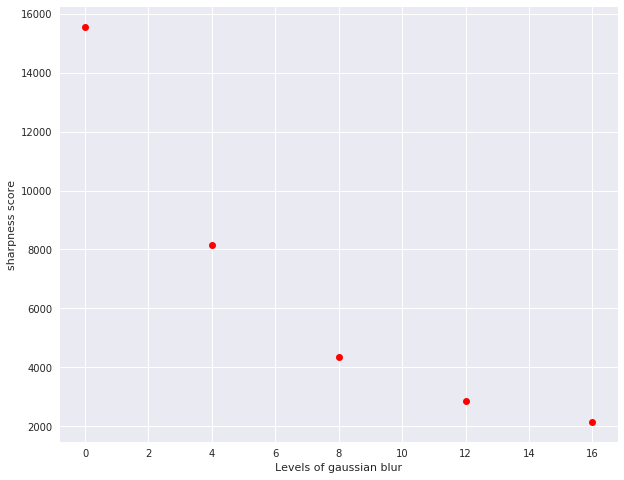

In [18]:

plt.figure(figsize=(10, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.xlabel('Levels of gaussian blur')
plt.ylabel('sharpness score')
plt.show()
plt.gcf().clear() 

### How well did the sharpness algorithm perform?  Try another algorithm to see if it performs better.

<br>
#### When you are completely finished running the notebook close the connection to IDR

In [36]:
conn.close()

This notebook is modified from the CalculateSharpness notebook created by Balaji Ramalingam